# Evaluating Imputation Against Ground Truth Abundance Values

In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

from pyproteonet.simulation import molecule_set_from_degree_distribution, simulate_protein_peptide_dataset, simulate_mcars, simulate_mnars_thresholding
from pyproteonet.aggregation import maxlfq
from pyproteonet.processing import logarithmize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulating a Dataset

In [17]:
# We define some degree distributions roughly assembling those of a real world dataset
protein_deg_distribution = [0, 0.1445, 0.1221, 0.1151, 0.0933, 0.0692, 0.0655, 0.0508, 0.0472, 0.0362, 0.0311, 0.0277, 0.0209, 0.0199, 0.0163, 0.0143,
                            0.012, 0.0105, 0.0093, 0.0087, 0.0081, 0.0063, 0.0063, 0.0055, 0.0054, 0.0043, 0.0043, 0.0042, 0.0039, 0.0037, 0.0034,
                            0.0031, 0.0022, 0.0021, 0.0019, 0.0019, 0.0019, 0.0015, 0.0012, 0.001, 0.001]
peptide_deg_distribution = [0, 0.9591, 0.0341, 0.0046, 0.0014]

First, we create a set of proteins with related peptides.
Next, we simulate abundance values for those peptides

In [50]:
# We create a simulated dataset with 100 proteins and 10 samples
num_proteins = 100
num_samples = 10

# We use a simple heuristic to determine the number of peptides for the given number of proteins while still closely matching the degree distributions
protein_degs = np.round(num_proteins * np.array(protein_deg_distribution))
prot_edges = np.sum(np.arange(len(protein_deg_distribution)) * protein_degs)
num_peptides = 1
pep_edges = 0
while pep_edges < prot_edges:
    num_peptides += 1
    peptide_degs = np.round(num_peptides * np.array(peptide_deg_distribution))
    pep_edges = np.sum(np.arange(len(peptide_deg_distribution)) * peptide_degs)
if pep_edges > prot_edges:
    diff = pep_edges - prot_edges
    for i in range(len(peptide_degs)-1, -1, -1):
        if peptide_degs[i] > 0 and i <= diff:
            peptide_degs[i] -= 1
            diff -= i
        if diff == 0:
            break

# Create a protein peptide molecule set for the given number of proteins/peptides and degree distribution
ms = molecule_set_from_degree_distribution(molecule1_name='protein', molecule2_name='peptide', mapping_name='peptide-protein',
                                           molecule1_degree_distribution=protein_degs, molecule2_degree_distribution=peptide_degs)
# Lets simulate some abundance values for the given molecule set
ds = simulate_protein_peptide_dataset(molecule_set=ms, mapping='peptide-protein', samples=num_samples,
                                      log_abundance_mu=15.9, log_abundance_sigma=1.8,
                                      log_protein_error_sigma=0.3, peptide_noise_sigma= 115005.3,
                                      flyability_alpha=0.7, flyability_beta=2.1, simulate_flyability=True)

Finally, we incorporate some missing values (MNARs and MCARs)

In [51]:
simulate_mnars_thresholding(dataset=ds, thresh_mu=115005.3 / 2, thresh_sigma=115005.3 / 4, molecule='peptide', column='abundance',
                            result_column='abundance_missing', mask_column='is_mnar', inplace=True)
simulate_mcars(dataset=ds, amount=0.3, molecule='peptide', column='abundance', result_column='abundance_missing', mask_column='is_mcar', inplace=True)

In [52]:
df = ds.values['peptide'].df
df.is_mnar.sum() / df.shape[0], df.is_mcar.sum() / df.shape[0]

(0.0, 0.2996688741721854)

In the end all abundance/aggregated values are logarithmized as it is commonly done in proteomics because logarithmized values are more normally distributed.

In [53]:
ds = logarithmize(data=ds, columns=['abundance', 'abundance_gt', 'abundance_missing'])

## MaxLFQ aggregation

In [54]:
ds.values['protein']['aggregated'] = maxlfq(dataset=ds, molecule='protein', mapping='peptide-protein', partner_column='abundance_missing',
                                            min_ratios=2, median_fallback=False, is_log=True)

Now the 'aggregated' value column holds the aggregated values and the 'abundance_gt' value column which was written during the simulation
holds the ground truth values

In [55]:
ds.values['protein'].df

abundance_gt  aggregated
sample  id                          
sample0 0         15.681         NaN
        1         16.349         NaN
        2         15.980         NaN
        3         15.953         NaN
        4         17.506         NaN
...                  ...         ...
sample9 92        16.108      16.049
        93        14.821      14.358
        94        16.364      16.816
        95        17.186      16.916
        96        17.538      17.259

[970 rows x 2 columns]

## Missing Value Imputation

Pyproteonet provides a wide range of established imputation functions combining both native python implementation and wrappers around R packages for imputation functions where no Python implementation is available yet. 

Here we use the high level api to impute on both protein and peptide level using a bunch of different imputation functions.

  0%|          | 0/7 [00:00<?, ?it/s]

minprob minprob
[1] 0.2529305
mindet mindet
bpca bpca
missforest missforest
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
knn knn
isvd isvd
[IterativeSVD] Iter 1: observed MAE=0.942344
[IterativeSVD] Iter 2: observed MAE=0.350876
[IterativeSVD] Iter 3: observed MAE=0.258267
[IterativeSVD] Iter 4: observed MAE=0.227213
[IterativeSVD] Iter 5: observed MAE=0.211764
[IterativeSVD] Iter 6: observed MAE=0.204686
[IterativeSVD] Iter 7: observed MAE=0.200392
[IterativeSVD] Iter 8: observed MAE=0.197704
[IterativeSVD] Iter 9: observed MAE=0.195750
[IterativeSVD] Iter 10: observed MAE=0.194525
[IterativeSVD] Iter 11: observed MAE=0.193618
15.146899784126177
dae dae


epoch,train_loss,valid_loss,time
0,725.728516,91.013054,00:00
1,709.095764,91.077766,00:00
2,708.331848,90.922592,00:00
3,705.660583,90.476593,00:00
4,696.783264,90.100899,00:00
5,685.555237,89.355019,00:00
6,672.083923,88.618347,00:00
7,653.671997,87.444458,00:00
8,632.348083,85.870407,00:00
9,608.691650,84.063354,00:00


  0%|          | 0/7 [00:00<?, ?it/s]

minprob minprob
[1] 0.2632525
mindet mindet
bpca bpca
missforest missforest
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
knn knn
isvd isvd
[IterativeSVD] Iter 1: observed MAE=3.272085
[IterativeSVD] Iter 2: observed MAE=0.941136
[IterativeSVD] Iter 3: observed MAE=0.464382
[IterativeSVD] Iter 4: observed MAE=0.322353
[IterativeSVD] Iter 5: observed MAE=0.266482
[IterativeSVD] Iter 6: observed MAE=0.237536
[IterativeSVD] Iter 7: observed MAE=0.219830
[IterativeSVD] Iter 8: observed MAE=0.208195
[IterativeSVD] Iter 9: observed MAE=0.200088
[IterativeSVD] Iter 10: observed MAE=0.194486
[IterativeSVD] Iter 11: observed MAE=0.190412
[IterativeSVD] Iter 12: observed MAE=0.187479
16.010288091787228
dae dae


epoch,train_loss,valid_loss,time
0,4493.552246,404.716217,00:00
1,4468.966309,404.322144,00:00
2,4447.557129,403.467987,00:00
3,4409.976562,402.153320,00:00
4,4379.576172,400.218506,00:00
5,4323.508301,397.358063,00:00
6,4260.140137,393.432800,00:00
7,4182.843750,388.475464,00:00
8,4094.818604,382.642151,00:00
9,3987.919189,375.565155,00:00


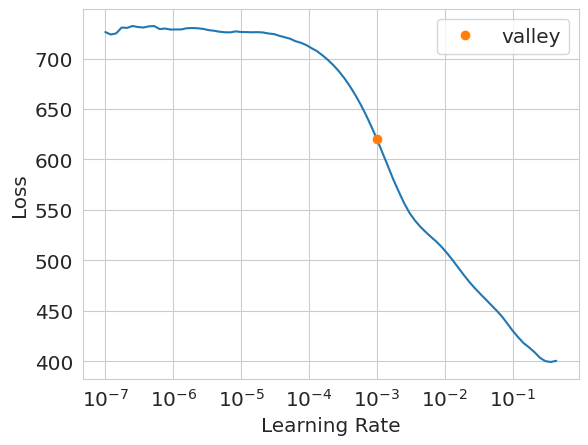

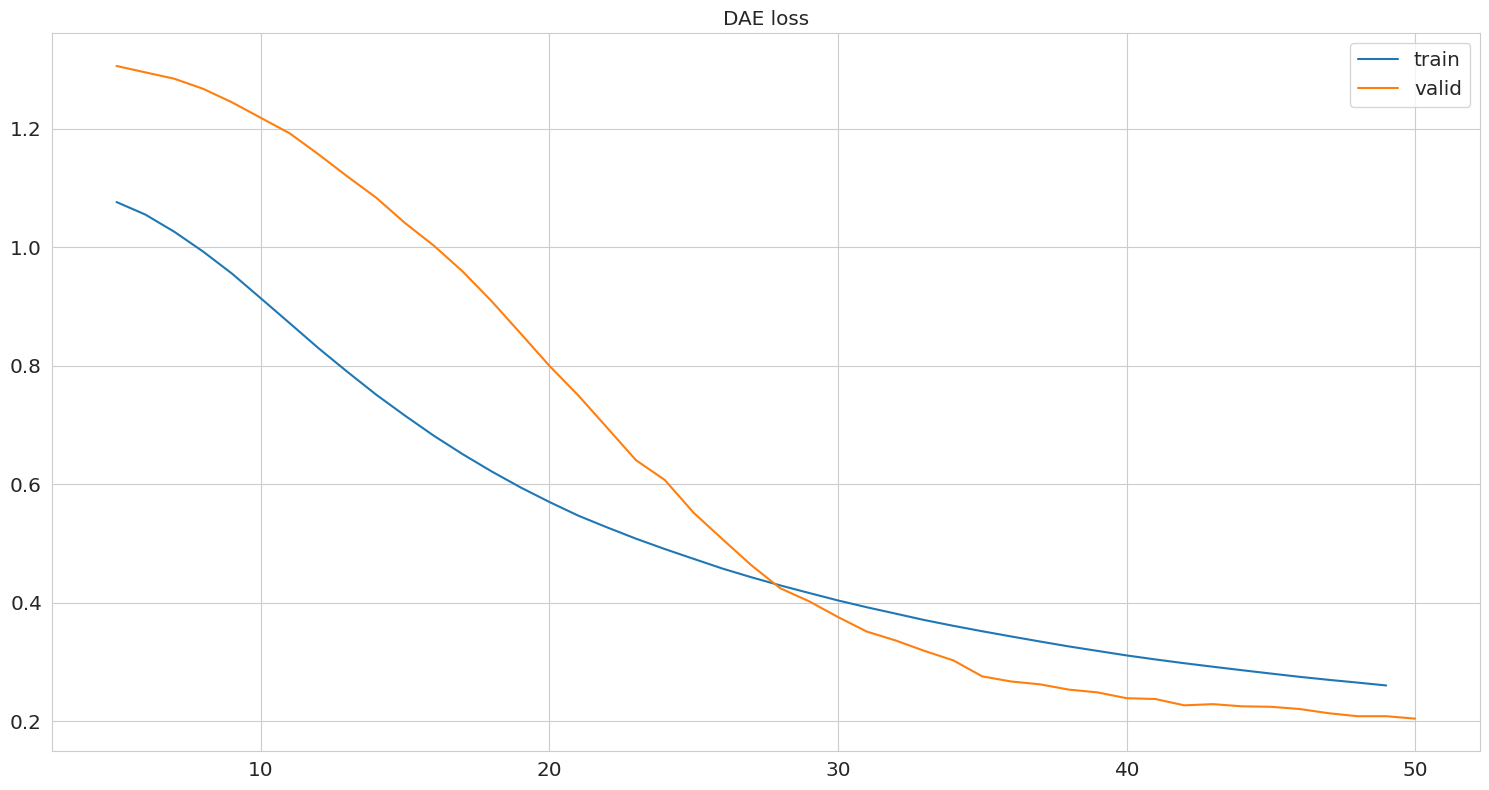

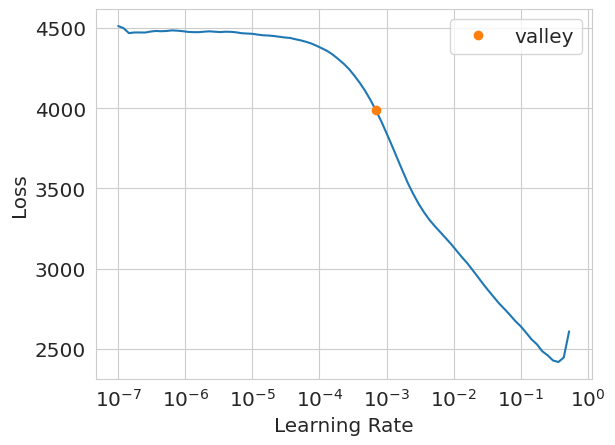

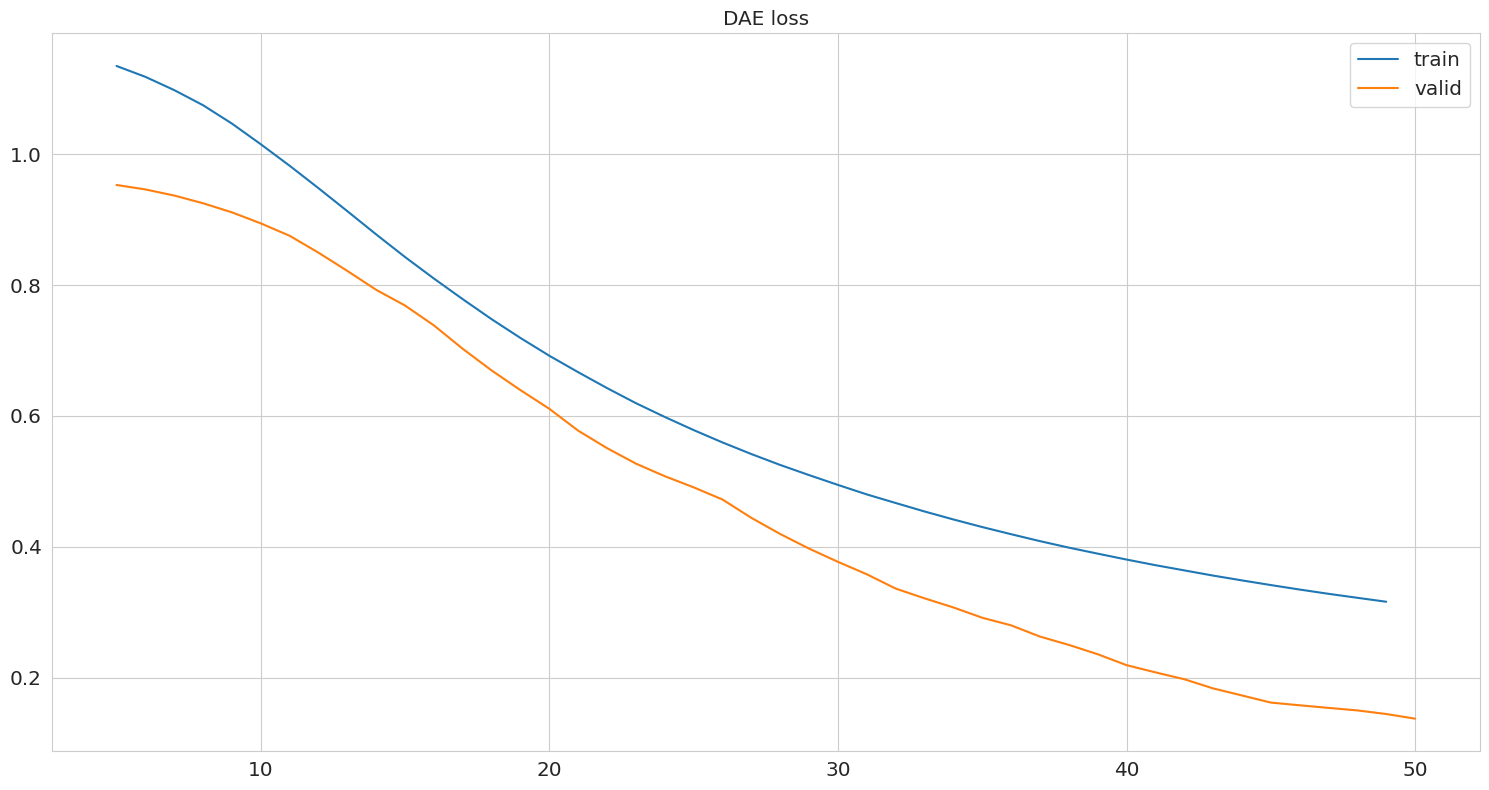

In [56]:
from pyproteonet.imputation import impute_molecule

imputation_methods = ["minprob", "mindet", "bpca", "missforest", "knn", "isvd", "dae"]

impute_molecule(dataset=ds, molecule='protein', column='aggregated', methods=imputation_methods)
impute_molecule(dataset=ds, molecule='peptide', column='abundance_missing', methods=imputation_methods)

Looking at the result we can see that the missing values are gone:

In [57]:
ds.values['peptide'].df

abundance  abundance_gt  abundance_missing  is_mnar  is_mcar  \
sample  id                                                                  
sample0 0       15.295        15.681             15.295    False    False   
        1       16.469        16.349                NaN    False     True   
        2       15.682        15.980                NaN    False     True   
        3       16.372        15.953             16.372    False    False   
        4       17.208        17.506             17.208    False    False   
...                ...           ...                ...      ...      ...   
sample9 599     17.746        17.807             17.746    False    False   
        600     18.388        18.548             18.388    False    False   
        601     17.853        18.019                NaN    False     True   
        602     18.369        18.595             18.369    False    False   
        603     18.173        18.284             18.173    False    False   

             minprob  mindet   bpca  missforest    knn   isvd    dae  
sample  id                                                            
sample0 0     15.295  15.295 15.295      15.295 15.295 15.295 15.295  
        1     12.429  12.393 16.614      16.566 16.625 16.446 16.406  
        2     12.489  12.393 15.963      15.642 16.131 16.075 15.713  
        3     16.372  16.372 16.372      16.372 16.372 16.372 16.372  
        4     17.208  17.208 17.208      17.208 17.208 17.208 17.208  
...              ...     ...    ...         ...    ...    ...    ...  
sample9 599   17.746  17.746 17.746      17.746 17.746 17.746 17.746  
        600   18.388  18.388 18.388      18.388 18.388 18.388 18.388  
        601   12.511  12.748 17.967      17.732 17.748 17.984 17.382  
        602   18.369  18.369 18.369      18.369 18.369 18.369 18.369  
        603   18.173  18.173 18.173      18.173 18.173 18.173 18.173  

[6040 rows x 12 columns]

### Graph Neural Network Imputation

In [73]:
from pyproteonet.imputation.dnn.gnn import impute_heterogeneous_gnn

_ = impute_heterogeneous_gnn(dataset=ds, molecule='protein', column='aggregated', mapping='peptide-protein', partner_column='abundance_missing',
                             molecule_result_column=f'gnn_hetero', partner_result_column=f'gnn_hetero',
                             max_epochs=1000, early_stopping_patience=7, epoch_size=30, training_fraction=0.25, log_every_n_steps=30)

seed: 351895759


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type            | Params
------------------------------------------------------
0 | embedding         | Embedding       | 485   
1 | molecule_fc_model | Sequential      | 11.0 K
2 | partner_fc_model  | Sequential      | 11.4 K
3 | molecule_gat      | HeteroGraphConv | 34.4 K
4 | partner_gat       | HeteroGraphConv | 50.4 K
5 | molecule_gat2     | HeteroGraphConv | 66.4 K
6 | molecule_linear   | Linear          | 820   
7 | partner_linear    | Linear          | 1.2 K 
8 | loss_fn           | GaussianNLLLoss | 0     
------------------------------------------------------
176 K     Trainable params
0         Non-trainable params
176 K     Total params
0.705     Total estimated model params size (MB)


Training: |                                                                                                   …

step29: num_masked_molecule:706.0 || num_masked_partner:1026.800048828125 || molecule_loss:0.5021055936813354 || partner_loss:0.4748190641403198 || train_loss:0.9769246578216553 || epoch:0 || 
step59: num_masked_molecule:706.0 || num_masked_partner:1160.433349609375 || molecule_loss:0.3709450662136078 || partner_loss:0.12557192146778107 || train_loss:0.49651697278022766 || epoch:1 || 
step89: num_masked_molecule:706.0 || num_masked_partner:1090.5333251953125 || molecule_loss:-0.012235956266522408 || partner_loss:-0.33215370774269104 || train_loss:-0.34438958764076233 || epoch:2 || 
step119: num_masked_molecule:706.0 || num_masked_partner:1158.4666748046875 || molecule_loss:-0.32520750164985657 || partner_loss:-0.4651690125465393 || train_loss:-0.790376603603363 || epoch:3 || 
step149: num_masked_molecule:706.0 || num_masked_partner:1099.7332763671875 || molecule_loss:-0.4504413902759552 || partner_loss:-0.510000467300415 || train_loss:-0.9604418873786926 || epoch:4 || 
step179: num_mas

Predicting: |                                                                                                 …

Just using pandas we can get the mean average error of the imputed values

In [61]:
df = ds.values['peptide'].df
for imp in imputation_methods + ['gnn_hetero']:
    print(imp, (df[imp] - df['abundance_gt']).abs().mean())

minprob 1.161707908701399
mindet 1.1617361347381416
bpca 0.1944661251166557
missforest 0.2203599013751484
knn 0.2181944885286117
isvd 0.22642413639656336
dae 0.27632932655821524
gnn_hetero 0.1984486647359422


Evaluating every dataset sample individually gives a better idea of the variance of imputation results.
For this the ```compare_columns(...)``` can be used, returning the evaluation results according to an evaluation metrics. Here we use the RMSE.
Those can then be plotted using seaborn.
We evaluate both, protein and peptide imputation.
In addition, only evaluating molecules with a missingness <= 80% allows for a more fine grained evaluation.

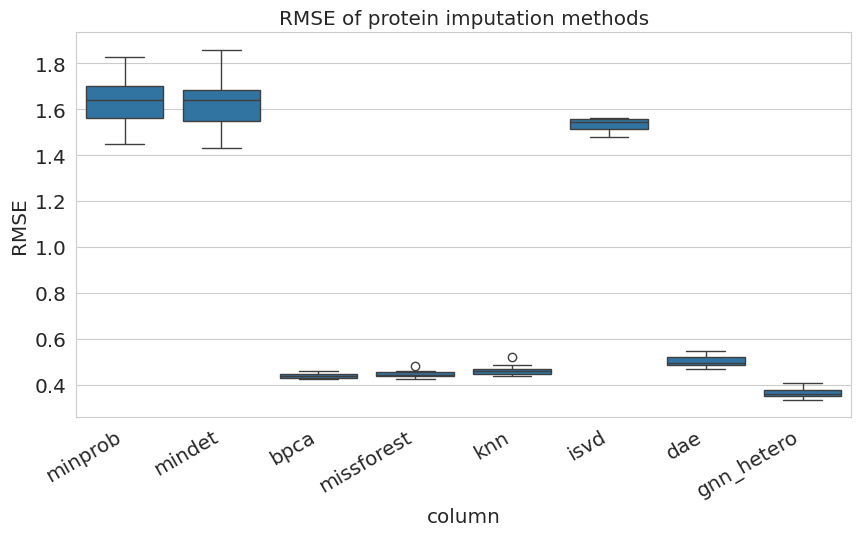

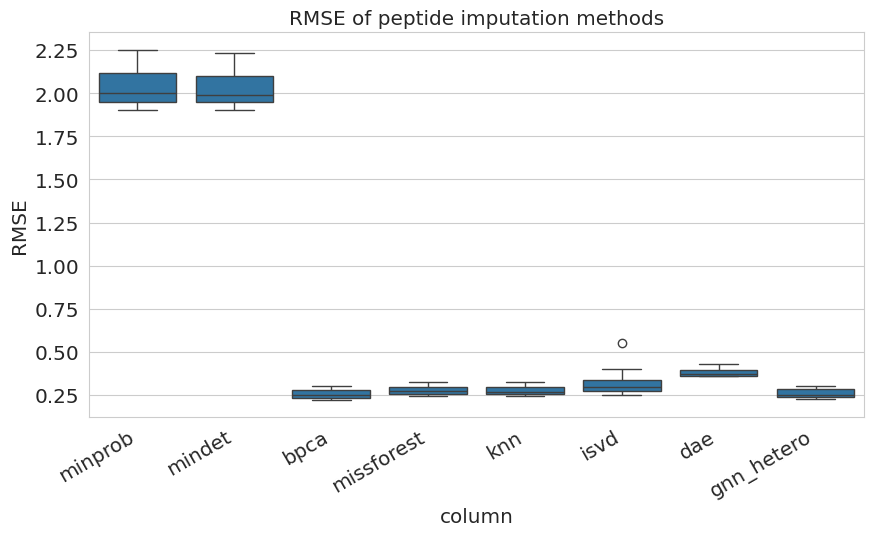

In [71]:
from matplotlib import pyplot as plt
import seaborn as sns

from pyproteonet.metrics import compare_columns


for molecule in ['protein', 'peptide',]:
    metric_df = compare_columns(
        dataset=ds,
        molecule=molecule,
        columns=imputation_methods + ['gnn_hetero'],
        comparison_column='abundance_gt',
        metric='RMSE',
        per_sample=True,
        ignore_missing=False,
        logarithmize=False,
        replace_nan_metric_with=0,
    )
    metric_df.rename(columns={"metric": 'RMSE'}, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = sns.boxplot(
        data=metric_df,
        x="column",
        y='RMSE',
        ax=ax
    )
    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha='right')
    ax.set_title(f'RMSE of {molecule} imputation methods')